Setup

In [3]:
import json
import math
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt

BENCHMARK_PATH = Path('').resolve().parent / 'benchmark'
RESULTS_PATH = BENCHMARK_PATH / 'results.json'
assert RESULTS_PATH.exists()

Process data into DataFrames

In [4]:
device_map = {
    'ClMatMul': [
        "Intel(R) UHD Graphics 630", "NVIDIA GeForce RTX 2060",
        "Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz"
        ],
    'ClMatMulComputeUnits': ["Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz"],
    }
results = json.load(open(RESULTS_PATH))
benchmarks = results['benchmarks']
context = {
    'ClMatMul':
        json.loads(results['context']['ClMatMul']),
    'ClMatMulComputeUnits':
        json.loads(results['context']['ClMatMulComputeUnits']),
    }
eigen = []
opencl = []
for b in benchmarks:
    if b.get('errors_ocurred', False):
        continue
    run = b['name'].split('/')
    test_name = run[0]
    test_suite = run[1]
    if test_suite == 'Eigen':
        eigen.append({
            'work': int(run[2]),
            'time': b['real_time'],
            'cpu_time': b['cpu_time'],
            })
    elif test_suite == 'OpenCL':
        device = context[test_name]['devices'][int(run[3])]['name']
        opencl.append({
            'work': int(run[2]),
            'device': device,
            'compute_units': int(run[4]) if len(run) > 4 else None,
            'time': b['real_time'],
            'cpu_time': b['cpu_time'],
            })
eigen = pd.DataFrame(eigen)
eigen['speed'] = eigen['work'] / eigen['time'] * 1000
opencl = pd.DataFrame(opencl)
opencl['speed'] = opencl['work'] / opencl['time'] * 1000
print(eigen.head())
print(opencl.head())

JSONDecodeError: Expecting ',' delimiter: line 1103 column 6 (char 32041)

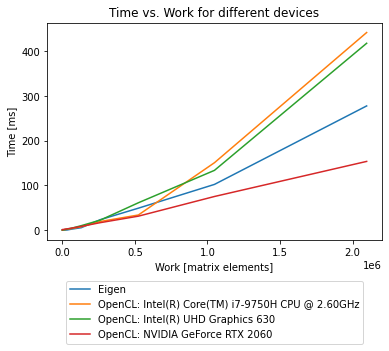

In [ ]:
ax = eigen.plot(
    x='work',
    y='time',
    label='Eigen',
    )
for name, group in opencl[opencl['compute_units'].isnull()].groupby('device'):
    group.plot(x='work', y='time', label=f"OpenCL: {name}", ax=ax)
ax.set_title('Time vs. Work for different devices')
ax.set_xlabel('Work [matrix elements]')
ax.set_ylabel('Time [ms]')
ax.figure.savefig(
    BENCHMARK_PATH / "time-work.png",
    bbox_extra_artists=(
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5)),
        ),
    bbox_inches='tight'
    )
None

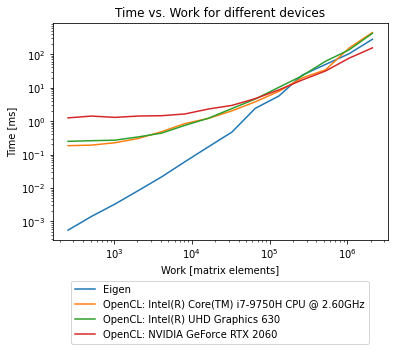

In [ ]:
ax = eigen.plot(
    x='work',
    y='time',
    label='Eigen',
    )
for name, group in opencl[opencl['compute_units'].isnull()].groupby('device'):
    group.plot(x='work', y='time', label=f"OpenCL: {name}", ax=ax)
ax.set_title('Time vs. Work for different devices')
ax.set_xlabel('Work [matrix elements]')
ax.set_ylabel('Time [ms]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.figure.savefig(
    BENCHMARK_PATH / "time-work-log.png",
    bbox_extra_artists=(
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5)),
        ),
    bbox_inches='tight'
    )
None

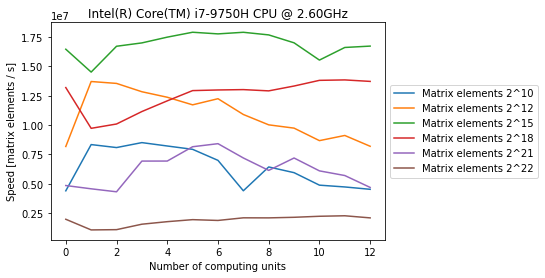

In [ ]:
for index, (name, group) in enumerate(
    opencl[~opencl['compute_units'].isnull()].groupby('device')
    ):
    _, ax = plt.subplots()
    for work, group in group.groupby('work'):
        group.plot(
            x='compute_units',
            y='speed',
            label=f"Matrix elements 2^{math.log2(work):.0f}",
            ax=ax
            )
    ax.set_title(device)
    ax.set_xlabel('Number of computing units')
    ax.set_ylabel('Speed [matrix elements / s]')
    ax.figure.savefig(
        BENCHMARK_PATH / f"d{index}-speed-units.png",
        bbox_extra_artists=(
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)),
            ),
        bbox_inches='tight'
        )

In [5]:
print(math.log2(32768))
print(math.log2(262144))
print(math.log2(2147483647))
print(math.log2(134217728))

15.0
18.0
30.999999999328193
27.0


34.99300625539349


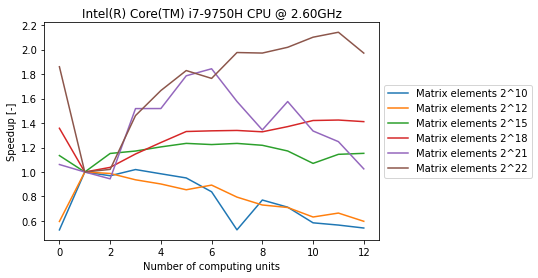

In [ ]:
for index, (name, group) in enumerate(
    opencl[~opencl['compute_units'].isnull()].groupby('device')
    ):
    print(
        math.log2(
            context['ClMatMulComputeUnits']['devices'][index]
            ['global_mem_size']
            )
        )
    _, ax = plt.subplots()
    for work, group in group.groupby('work'):
        group['speedup'] = group['speed'] / int(
            group[group['compute_units'] == 1]['speed']
            )
        group.plot(
            x='compute_units',
            y='speedup',
            label=f"Matrix elements 2^{math.log2(work):.0f}",
            ax=ax
            )
    ax.set_title(device)
    ax.set_xlabel("Number of computing units")
    ax.set_ylabel("Speedup [-]")
    ax.figure.savefig(
        BENCHMARK_PATH / f"d{index}-speedup-units.png",
        bbox_extra_artists=(
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)),
            ),
        bbox_inches='tight'
        )
